<a href="https://colab.research.google.com/github/ThomasMiconi/HebbianCNNPyTorch/blob/main/HebbGrad_Simple_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code shows a simple example of a 3-layer convolutional network with Hebbian learning. 

It's simple and short with lots of comments, for didactic purposes. However, it is fully functional and offers some options.

We use the CIFAR10 dataset in grayscale mode, so that we can approximately decorrelate (whiten) the images with a simple difference-of-Gaussians filter. We use simple winner-take-all (k-WTA) competition at each layer.

First, some standard PyTorch boilerplate. Note the large batch size.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pdb
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
# from scipy import linalg

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time

import numpy as np


BATCHSIZE=100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = transforms.Compose([
torchvision.transforms.Grayscale(),
torchvision.transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(
   root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
   trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=2) # Also check out pin_memory if using GPU
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Then we define some hyperparameters and initialize the model.
 
If you modify the size parameters, be sure to look at the size of the final layer (which will be displayed when you run the network below): if you end up with a 1x1 top layer, performance will be poor.

In [15]:
NL=3                    # Number of layers 
STRIDES=(1,1,1)         # Input strides (for each layer)    
POOLSTRIDES = (2, 2, 2) # Pooling strides
POOLDIAMS = (2, 2, 2)   # Pooling diameters
SIZES = (5, 3, 3)       # Receptive field sizes
N = [100, 196, 400]     # N = number of cells per column (i.e. channels) for each layer
K = [1, 1, 1]           # K = number of winners in the winner-take-all (WTA) competition

TARGETRATE = [float(K[ii] / N[ii]) for ii in range(NL)]   #  The target winning rate of each cell *must* be K/N to allow for equilibrium

CSIZE = 32              # Input image size
FSIZE = 12              # Size of the Difference-of-Gaussians filter
NBLEARNEPOCHS = 5       # Number of epochs for Hebbian learning (2 more epochs are added for data acquisition for training and testing the linear classifier)
LR = 0.01 / BATCHSIZE   # Learning rate
MUTHRES =   10.0        # Threshold adaptation rate

USETRIANGLE = False     # Should we use Coates' "triangle" method to compute actual neural responses, or should we just use the WTA result as is?

tic = time.time()

# Initializations
w=[]
optimizers=[]
thres=[]
for numl in range(NL):
    NIC = 1 if numl == 0 else N[numl-1]  # Number of input channels for the weight filters at each layer
    wi = torch.randn((N[numl], NIC, SIZES[numl], SIZES[numl]), requires_grad=True, device=device) 
    wi.data = wi.data  / (1e-10 + torch.sqrt(torch.sum(wi.data ** 2, dim=[1,2,3], keepdim=True))) # Weights have norm 1
    w.append(wi)
    thres.append(torch.zeros((1,N[numl],1,1), requires_grad=False).to(device))  # Thresholds (i.e. adaptive biases to ensure a roughly equal firing rate)
    optimizers.append(optim.SGD((w[numl],), lr=LR, momentum=0.0))       # We use one optimizer per layer, though this is not strictly necessary with judicious use of .detach()              


# Build a difference-of-Gaussians kernel to spatially decorrelate (approximately whiten) the images
gk1 = np.zeros((FSIZE, FSIZE)); gk1[FSIZE//2, FSIZE//2] = 1
gk2 = (scipy.ndimage.gaussian_filter(gk1,sigma=.5) - scipy.ndimage.gaussian_filter(gk1,sigma=1.0))
dog = torch.Tensor(gk2[np.newaxis,np.newaxis,:,:]).to(device) #  Adding two singleton dimensions for input and output channels (1 each)



print("Initialization time:", time.time()-tic, "Device:", device)
testtargets = traintargets = []; testouts = trainouts = []
tic = time.time()
firstpass=True
nbbatches = 0


Initialization time: 0.003704547882080078 Device: cuda


Now we can run the network!

In [9]:
for epoch in range(NBLEARNEPOCHS+2):

    print("Epoch", epoch)

    myloader = testloader if epoch == NBLEARNEPOCHS +1 else trainloader
    for numbatch, (x, targets) in enumerate(myloader):

        nbbatches += 1

        # Prepare the input images and decorrelate them with the difference-of-gaussian filters
        with torch.no_grad():         
            x = x.to(device); targets = targets.to(device)
            x = x - torch.mean(x, dim=(1, 2,3),keepdim=True)
            x = x / (1e-10 + torch.std(x, dim=(1, 2,3), keepdim=True)) 
            x = F.conv2d(x, dog, groups=1, padding=FSIZE//2)    # DoG filtering 


        # Now run the network's layers in succession
        
        for numl in range(NL):

            optimizers[numl].zero_grad()  # We use one optimizer per layer for added clarity, but this is not strictly necessary (with judicious use of .detach() to stop gradient flow)

            # We normalize the input
            with torch.no_grad():
                x = x - torch.mean(x, dim=(1, 2,3),keepdim=True);  x = x / (1e-10 + torch.std(x, dim=(1, 2,3), keepdim=True)) 

            # We apply the weight convolutions, giving us the feedforward input into each cell (and building the first part of the computational graph)
            prelimy = F.conv2d(x, w[numl], stride=STRIDES[numl])

            # Then we compute the "real" output (y) of each cell, with winner-take-all competition
            with torch.no_grad():                
                realy = (prelimy - thres[numl])
                tk = torch.topk(realy.data, K[numl], dim=1, largest=True)[0]
                realy.data[realy.data < tk.data[:,-1,:,:][:, None, :, :]] = 0       
                realy.data = (realy.data > 0).float()

            # Then we compute the surrogate output yforgrad, whose gradient computations produce the desired Hebbian output
            # Note: We must not include thresholds here, as this would not produce the expected gradient expressions. The actual values will come from realy, which does include thresholding.

            yforgrad = prelimy - 1/2 * torch.sum(w[numl] * w[numl], dim=(1,2,3))[None,:, None, None]                # Instar rule, dw ~= y(x-w)  
            # yforgrad = prelimy - 1/2 * torch.sum(w[numl] * w[numl], dim=(1,2,3))[None,:, None, None] * realy.data # Oja's rule, dw ~= y(x-yw)
            # yforgrad = prelimy                                                                                    # Plain Hebb, dw ~= xy

            yforgrad.data = realy.data # We force the value of yforgrad to be the "correct" y

            # We perform the backward pass and the learning step, which applies the desired Hebbian updates
            loss = torch.sum( -1/2 * yforgrad * yforgrad) 
            loss.backward()
            if nbbatches > 100 and epoch < NBLEARNEPOCHS:  # No weight modifications before batch 100 (burn-in) or after learning epochs (during data accumulation for training / testing)
                optimizers[numl].step()              
                w[numl].data =  w[numl].data / (1e-10 + torch.sqrt(torch.sum(w[numl].data ** 2, dim=[1,2,3], keepdim=True)))  # Weight normalization

            # We show the sizes of the layers. Watch especially the size of the last layer - if it's just 1x1, there won't be a lot of information there.
            if firstpass:
                print("Layer", numl, ": x.shape:", x.shape, "y.shape (before MaxP):", realy.shape, end=" ")

            # Apply pooling to produce the input of the next layer (or the final network output)
            with torch.no_grad():
                x = F.avg_pool2d(realy, POOLDIAMS[numl], stride=POOLSTRIDES[numl]).detach()       

                if firstpass:
                    print("y.shape (after MaxP):", x.shape)  # The layer's final output ("y") is now x for the next step

                # Threshold adaptation is based on realy, i.e. the one used for plasticity. Always binarized (firing vs. not firing).
                thres[numl] +=  MUTHRES *   (torch.mean((realy.data > 0).float(), dim=(0,2,3))[None, :, None, None] -  TARGETRATE[numl])


        # After all layers are done

        if epoch >= NBLEARNEPOCHS:  # Collecting data to train and test a linear classifier, based on (frozen) network response to the training and testing datasets, respectively.
            # We simply collect the outputs of the network, as well as the labels. The actual training/testing will occur below, with a linear classifier.
            if epoch == NBLEARNEPOCHS:
                testtargets.append(targets.data.cpu().numpy())
                testouts.append(x.data.cpu().numpy())
            elif epoch ==NBLEARNEPOCHS + 1:
                traintargets.append(targets.data.cpu().numpy())
                trainouts.append(x.data.cpu().numpy())
            else:
                raise ValueError("Too many epochs!")

        firstpass = False 


    # After all batches for this epoch are done

    #if nbbatches % 1000 == 0: 
    print("Number of batches after epoch", epoch,  ":", nbbatches, "- time :", (time.time()-tic), "s")
    tic =  time.time()



print("Training done..")





Epoch 0
Layer 0 : x.shape: torch.Size([100, 1, 33, 33]) y.shape (before MaxP): torch.Size([100, 100, 29, 29]) y.shape (after MaxP): torch.Size([100, 100, 14, 14])
Layer 1 : x.shape: torch.Size([100, 100, 14, 14]) y.shape (before MaxP): torch.Size([100, 196, 12, 12]) y.shape (after MaxP): torch.Size([100, 196, 6, 6])
Layer 2 : x.shape: torch.Size([100, 196, 6, 6]) y.shape (before MaxP): torch.Size([100, 400, 4, 4]) y.shape (after MaxP): torch.Size([100, 400, 2, 2])
Number of batches after epoch 0 : 500 - time : 10.383488893508911 s
Epoch 1
Number of batches after epoch 1 : 1000 - time : 9.932765483856201 s
Epoch 2
Number of batches after epoch 2 : 1500 - time : 10.010273933410645 s
Epoch 3
Number of batches after epoch 3 : 2000 - time : 9.994359970092773 s
Epoch 4
Number of batches after epoch 4 : 2500 - time : 9.882179975509644 s
Epoch 5
Number of batches after epoch 5 : 3000 - time : 9.901130676269531 s
Epoch 6
Number of batches after epoch 6 : 3100 - time : 2.0713253021240234 s
Train

Here we build a linear classifier with the data collected in the last two epochs of the previous loops (while weights were frozen).

In [10]:

# Converting target indices to one-hot:
tgt_idx = np.hstack(traintargets)
tgt = np.zeros((tgt_idx.shape[0], 10))
tgt[np.arange(tgt_idx.shape[0]), tgt_idx] = 1
print(tgt[:4,:])
print(tgt_idx[:4])

USESVC = False  # Support Vector Classifier is slightly better, but extremely slow.

# Flattening the network outputs
zetrainouts = trainouts; zetestouts = testouts

inputs_f = [np.reshape(z, (z.shape[0], -1)) for z in zetrainouts] 
inputs = np.vstack(inputs_f)

print(tgt.shape)
print(inputs.shape)


import sklearn
from sklearn import svm
from sklearn import linear_model

tic = time.time()

if USESVC:
    clf = svm.LinearSVC(dual=False)
    clf.fit(inputs, tgt_idx)
else:
    clf = linear_model.Ridge()   # Simple linear ridge regression of the 1-hot labels over the network outputs
    clf.fit(inputs, tgt)

print("Time:", time.time() - tic)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[4 0 5 7]
(60000, 10)
(60000, 1600)
Time: 2.467410087585449


Now we apply the classifier to data from the testing set and compute overall test accuracy.

In [11]:
tgt_idx = np.hstack(testtargets)
tgt = np.zeros((tgt_idx.shape[0], 10))
tgt[np.arange(tgt_idx.shape[0]), tgt_idx] = 1

inputs_f = [np.reshape(z, (z.shape[0], -1)) for z in zetestouts] 
inputs = np.vstack(inputs_f)

if USESVC: 
    t = clf.predict(inputs)
    print(np.mean(tgt_idx==t))

else:
    t = clf.predict(inputs)
    tm = np.argmax(t, axis=1)
    # print(tm[:10])
    # print(tgt_idx[:10])
    tacc = np.mean(tgt_idx==tm)
    print("Test accuracy:", tacc)


Test accuracy: 0.43143333333333334


Display the learned receptive fields, for each layer.

RF size for layer 2 : 10  - Step size: 2
RF size for layer 3 : 20  - Step size: 4


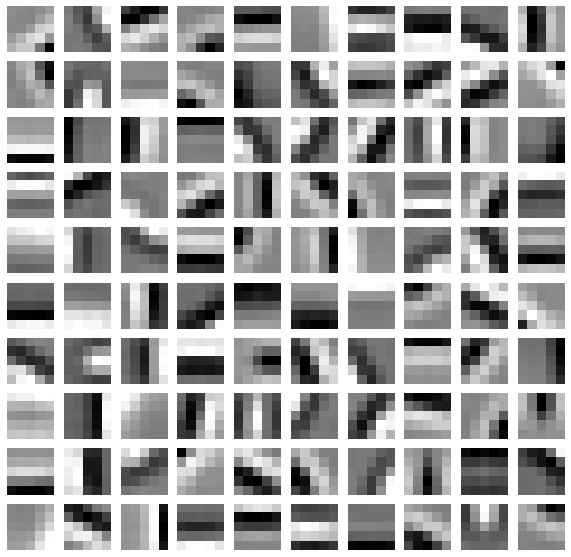

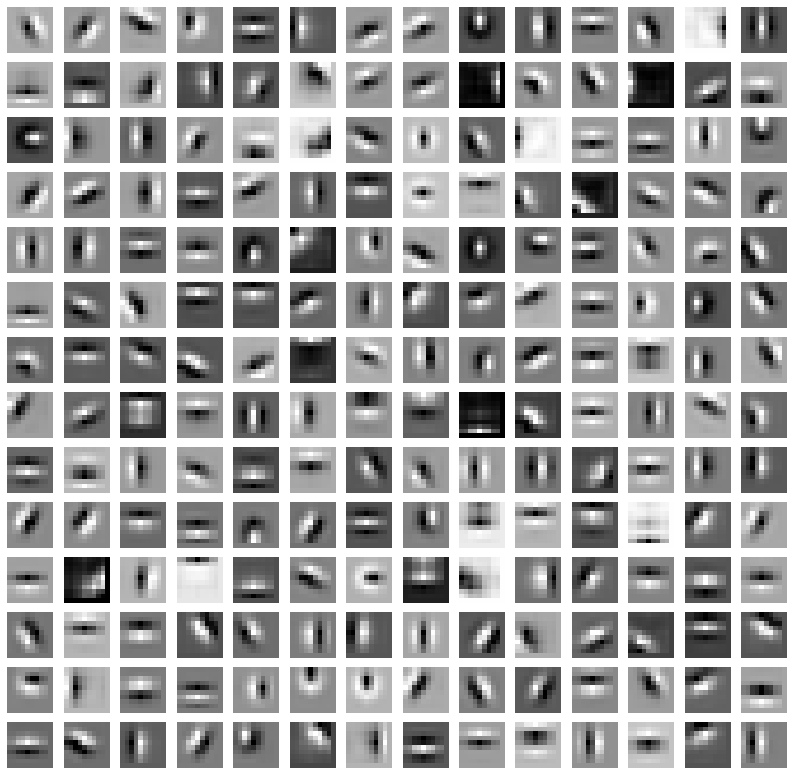

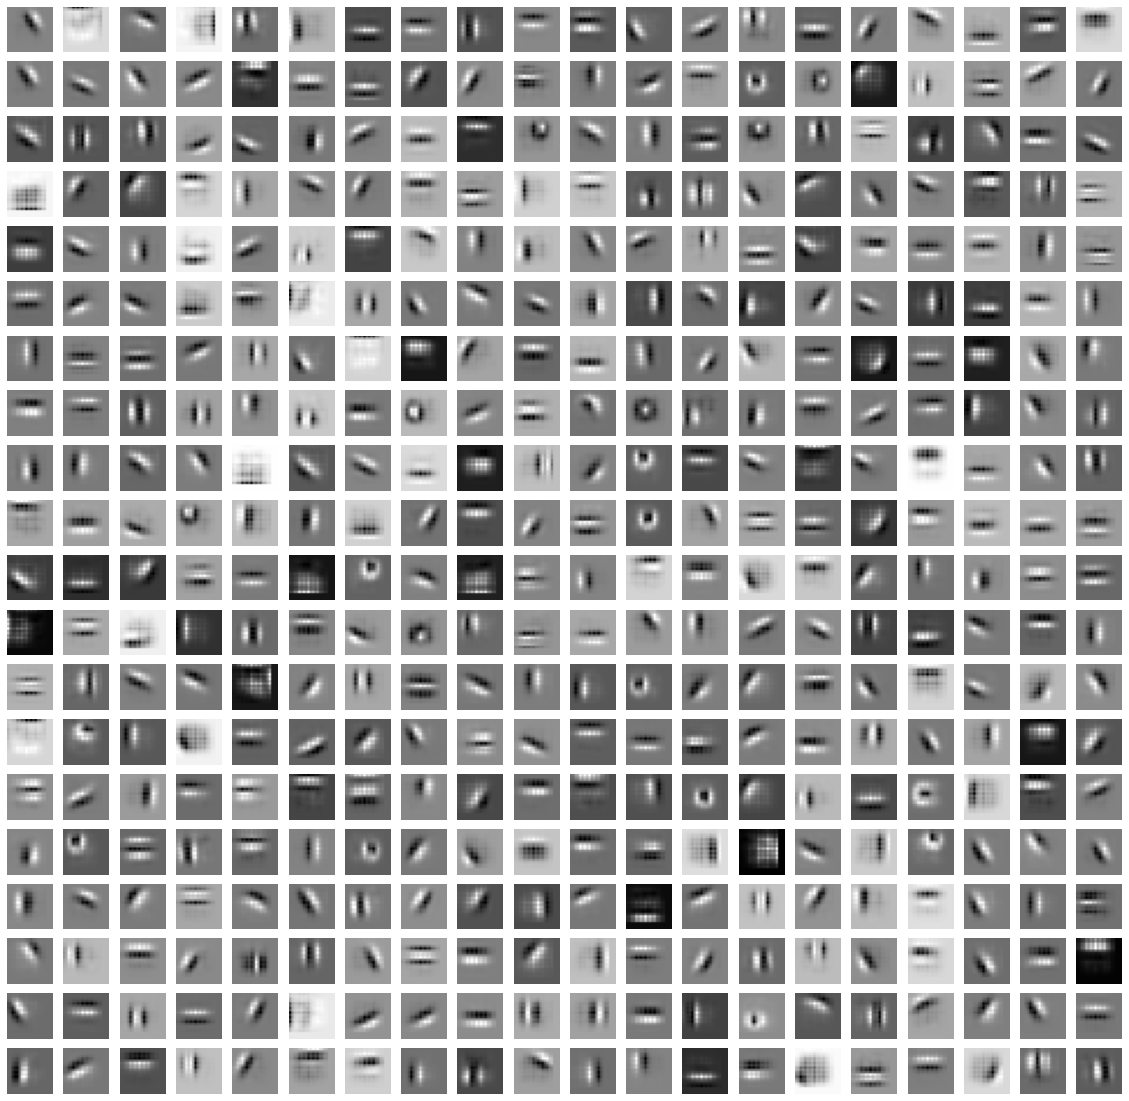

In [12]:

# Displaying weights in the previous, HxW convolutional format
#rfs=[]
rfsL1unnorm = []
rfsizes= [SIZES[0]]
figs=[]
stepsizes=[1]
fig = plt.figure(figsize=(np.sqrt(N[0]), np.sqrt(N[0])))
wnp = w[0].data.cpu().numpy()
#wnp = wnp - np.min(wnp); wnp = wnp / np.max(wnp)
for numpic in range(N[0]):
    ax = plt.subplot(np.ceil(np.sqrt(N[0])), np.ceil(np.sqrt(N[0])), numpic+1)

    wn = wnp[numpic,:,:,:]
    assert(wn.shape[0] == 1)  # only 1 input channel, because grayscale
    wn = np.repeat(wn, 3, axis=0)
    wn = np.moveaxis(wn, 0, 2)
    rfsL1unnorm.append(wn)
    wn = .5 + .5 * wn / (1e-10 + np.max(np.abs(wn)))  # all values lie within [0, 1], with 0 being .5
    #wn = wn-np.min(wn); wn = wn / (1e-9 + np.max(wn))
    #wn[:,:,0]=0
    ax.imshow(wn)
    ax.set_axis_off()

figs.append(fig)
rfsunnorm = [np.stack(rfsL1unnorm, axis=0)]
# rfL2size = STRIDES[0] * MPSTRIDES[0]*DILATIONS[1]*(SIZES[1]-1)+SIZES[0]
# rfL3size = STRIDES[1] * MPSTRIDES[1]*STRIDES[0] * MPSTRIDES[0]*DILATIONS[1] * (SIZES[2]-1)+rfL2size
# I get rid of dilations because they're probably wrong
for numl in range(1,NL):
        wnp = w[numl].cpu().detach().numpy()
        stepsize = POOLSTRIDES[numl-1]*STRIDES[numl-1]*stepsizes[numl-1] # Step size (in pixels) b/w successive input RFs within my own RF; would also be the step size b/w successive me's, but neglecting my own MPstride and next levels's stride
        stepsizes.append(stepsize)
        rfsize = stepsize * (SIZES[numl] - 1) + rfsizes[numl-1] + (POOLDIAMS[numl-1]-1) * stepsizes[numl-1]
        rfsizes.append(rfsize)
        print("RF size for layer", str(numl+1), ":", rfsize, " - Step size:", stepsize)
        #rfsthislayer = []
        rfsthislayerunnorm = []
        fig = plt.figure(figsize=(np.sqrt(N[numl]), np.sqrt(N[numl])))
        for nn in range(N[numl]):
            ax = plt.subplot(np.ceil(np.sqrt(N[numl])),np.ceil(np.sqrt(N[numl])),nn+1)
            wn = wnp[nn,:,:,:]
            #print(np.sort(wn[:,3,0]))
            pic = np.zeros((rfsize, rfsize, 3))
            for xin in range(SIZES[numl]):
                for yin in range(SIZES[numl]):
                    avgrf = wn[:, xin, yin][:, np.newaxis, np.newaxis, np.newaxis] * rfsunnorm[numl-1]
                    avgrf = np.sum(avgrf, axis=0)
                    pic[xin*stepsize:xin*stepsize+rfsizes[numl-1], yin*stepsize:yin*stepsize+rfsizes[numl-1],:] += avgrf
                    
                    # For L3: 
                    # avgrf = wn[:, xin, yin][:, np.newaxis, np.newaxis, np.newaxis] * rfsL2unnorm
                    # avgrf = np.sum(avgrf, axis=0)
                    # rx = xin*STRIDES[1]*MPSTRIDES[1]*STRIDES[0]*MPSTRIDES[0]*DILATIONS[1]; ry = yin*STRIDES[1]*MPSTRIDES[1]*STRIDES[0]*MPSTRIDES[0]*DILATIONS[1]
                    # pic[rx:rx+rfL2size, ry:ry+rfL2size,:] += avgrf

            rfsthislayerunnorm.append(pic)
            pic = pic-np.min(pic); pic = pic / (1e-9 + np.max(pic))
            ax.imshow(pic)
            ax.set_axis_off()
            #rfsthislayer.append(pic)
        rfsunnorm.append(np.stack(rfsthislayerunnorm, axis=0))
        figs.append(fig)

# Save the figures as .png files:
# for numl in range(NL):        
#     figs[numl].savefig("FigRFs"+str(numl+1)+"_simple.png")


Plot the distribution of weights in the last layer (log scale).

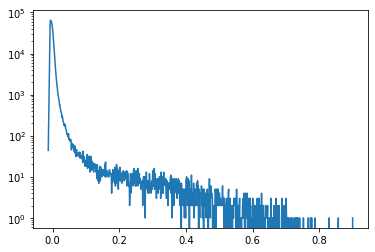

In [13]:
plt.figure()
hh=np.histogram(w[2].data.cpu().numpy().flat, 1000)
z=hh[0]; b = hh[1][:-1]
np.savez(  'hist.npz', b, z)
#z[z>100]=100
plt.yscale('log')
plt.plot(b,z)
